In [1]:
import sys
import os

In [2]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [3]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
from tqdm.auto import tqdm
from ase.eos import EquationOfState
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rc('font', size=20)
plt.rc('figure', figsize=(18,6))

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Defino otras funciones de conveniencia:

In [5]:
# Para graficar convergencia de energía.
def econvergence(E: list):
    return np.abs((E[:-1] - E[-1])/E[-1])

# Para almacenar cálculos.
def load_calc(filename, **kwargs):
    if os.path.exists(filename):
        calc = GPAW(filename)
    else:
        calc = GPAW(**kwargs)
    return calc

# Para borrar elementos del diccionario.
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r
        

# Generación de las estructuras

La función [ase.build.bulk](https://wiki.fysik.dtu.dk/ase/ase/build/build.html?highlight=build) genera estructuras bulk. Los Input son la composición química, la estructura cristalina, el parámetro de red y si se quiere una celda convencional o primitiva. El Output es un [objeto Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms), que permitirá luego manipular sus componentes. Se puede pensar en estos objetos como listas de [objetos Atom](https://wiki.fysik.dtu.dk/ase/ase/atom.html#ase.atom.Atom), de átomos individuales.

## Estructura del **Si puro** (sin dopar)

El **Si en equilibrio** forma una [estructura cúbica de tipo diamante](https://nomad-lab.eu/prod/rae/encyclopedia/#/material/fh3UBjhUVm4nxzeRd2JJuqw5oXYa/structure). Posee 8 átomos por celda.

In [6]:
SiDiamond = bulk('Si', 'diamond', a=4., cubic=True)

Número de átomos de la estructura.

In [7]:
N_Si_puro = SiDiamond.get_global_number_of_atoms()
print(N_Si_puro)

8


In [8]:
printatoms = [print(at) for at in SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


Luego, con la función "plot_atoms" podemos visualizarlos. Sólo es útil para visualizar la estructura rápidamente en el Jupyter Notebook, pero la verdad es que no es muy buena.

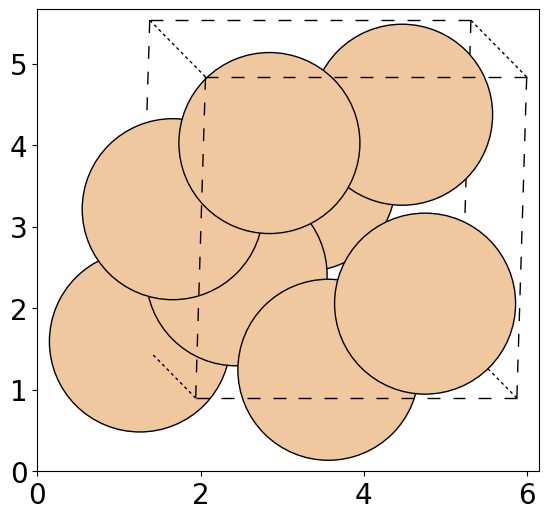

In [9]:
fig, ax = plt.subplots()
plot_atoms(SiDiamond, rotation='10x, 10y', ax=ax)

Una forma más presentable de visualizar las estructuras es usando por ejemplo [VESTA](http://www.jp-minerals.org/vesta/en/download.html). 

## Estructura del **Si7P1** (Si dopado)

**Es importante destacar** que las simulaciones de dopado de Si se realizan con superceldas, las cuales poseen un número de átomos de Si mucho mayor al empleado en la simulación que se llevará a cabo en este trabajo. El motivo por el cual no se simuló una supercelda es el tiempo disponible para llevar a cabo el trabajo. 

Atom('P', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


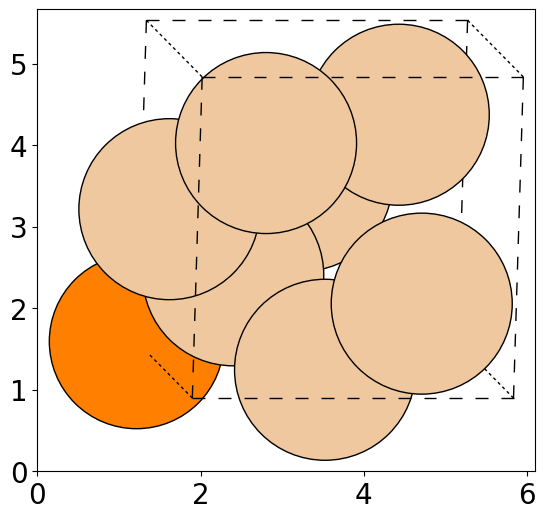

In [10]:
# Creo lista normal, con los elementos de la original "SiDiamond".
SiDiamondList = [at for at in SiDiamond]
# Con "atom" defino el átomo de P, le asigno posición que tenía el Si en "SiDiamond", y guardo en la lista "SiDiamondList".
SiDiamondList[0]=Atom('P', position=SiDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "SiDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir de
# lo que contiene "SiDiamondList".
SiPDiamond=Atoms(SiDiamondList, cell=SiDiamond.cell, pbc=True)

print_new_atoms = [print(at) for at in SiPDiamond]

plot_atoms(SiPDiamond, rotation='10x, 10y')

Número de átomos de la estructura.

In [11]:
N_Si_P = SiPDiamond.get_global_number_of_atoms()
print(N_Si_P)

8


# Tareas
1.  convergencia en puntos K y en ondas planas
2. Calcular curva E-V  y ajustar parámetro de red. ¿ Cambia mucho al cambiar un átomo solo ?
3. Calcular estructura electrónica, i.e. densidad de estados. ¿Qué cambia ? 

# Definimios la calculadora

Se va a emplear el código GPAW, que utiliza el método proyector de ondas aumentadas (PAW), para calcular mediante DFT la energía potencial de las estructuras cristalinas definidas. 

## **Si puro**

In [12]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiDiamondExample.txt',kpts=[5,5,5])
SiDiamond.set_calculator(calc)
SiDiamond.get_potential_energy()

30.841227127871782

## **Si7P1**

In [13]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiPDiamondExample.txt',kpts=[5,5,5])
SiPDiamond.set_calculator(calc)
SiPDiamond.get_potential_energy()

27.629724563844576

**Conclusión:** Al dopar Si diamante con un átomo de P en la posición (0,0,0), *la energía potencial se reduce prácticamente un 10%*.

**Sin embargo**, esto no significa nada porque para el cálculo del Si puro se emplean pseudopotenciales diferentes a los utilizados en el cálculo del Si7P1, por lo que si en realidad se quisiera determinar la estabilidad relativa de ambos compuestos deberían calcularse sus respectivas energías de formación:

$$ \Delta E_f = \dfrac{1}{N} \left( E_{compuesto} - \sum_{i} n_i E_i \right) $$

, donde $N$ es el número de átomos, $E_{compuesto}$ [eV] es la energía del compuesto calculada, $n_i$ [át] es el número de átomos de la especie $i$ en el compuesto y $E_i$ [eV/át] es la energía por átomo del compuesto $i$ en su estructura de equilibrio.

**En el presente trabajo**, se empleará $\Delta E_f$ como método de evaluación de convergencia.

# K-point convergence

Defino las estructuras en las que evaluaré la convergencia en puntos K:
- $SiDiamond$, corresponde a **Si puro**. Se asumió parámetro de red $a = 5,5$ Å como primera aproximación, por información encontrada en bibliografía.
- $SiPDiamond$, corresponde a **Si7P1**. Se asumió parámetro de red $a = 5,65$ Å (**ERRÓNEAMENTE**, porque al poseer el P menor radio atómico que el Si, **debería haber tomado** $a = 5,35$ Å).

In [14]:
structures = [('pure', SiDiamond, 5.5), ('wPhos', SiPDiamond, 5.65)] # Nombre, estructura, parámetro de red.

Defino diferentes puntos K en los que se grillarán las estructuras. Se buscará a partir de cuál el cálculo converge.

In [15]:
kpoints = [3, 4, 5,7,9,11,13,14,15] # Grillas a ensayar
Ekpt = {} # Guardaré, para cada estructura (name), la información de las grillas en un diccionario

Para no tener que hacer las cuentas de nuevo cada vez que se corre este loop, se define un archivo donde se guardan los resultados y probar si existe antes de hacer la cuenta de nuevo (ahorra tiempo).

In [16]:
import os

In [17]:
calcsdir='calcs_kpoints'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [18]:
import pdb

In [19]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        gpawfile =os.path.join(calcsdir, f'{name}_kpts_{kpt}.gpaw')
        logfile = os.path.join(calcsdir, f'{name}_{kpt}.txt')
        # Energía cinética de corte 300 eV. Divido celda en grilla de "kpt*kpt*kpt".
        calc = load_calc(gpawfile, mode=PW(300), txt=logfile, xc='PBE', kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(gpawfile)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Imprimo energías potenciales de **Si puro**

In [20]:
print(Ekpt['pure'])

[3.82942361 3.84226176 3.85515339 3.85366022 3.84680203 3.84643687
 3.84849821 3.8486624  3.8487114 ]


In [21]:
print(len(Ekpt['pure']))

9


In [22]:
print(Ekpt['pure'][0])

3.8294236080809965


In [23]:
print(Ekpt['pure'][1])

3.8422617589764547


Imprimo energías potenciales de **Si7P1**

In [24]:
print(Ekpt['wPhos'])

[3.45943712 3.45237747 3.45371557 3.46262626 3.46039118 3.45954958
 3.45933754 3.45947533 3.45966696]


In [25]:
print(len(Ekpt['wPhos']))

9


In [26]:
print(Ekpt['wPhos'][0])

3.459437123011021


In [27]:
print(Ekpt['wPhos'][1])

3.4523774732961554


***Convergencia del Si7P1:*** Se calculó su energía de formación $\Delta E_f$, siguiendo la expresión:

$$ \Delta E_f = \frac{E_{Si7P1}}{N} - \frac{1}{N} \left( n_{Si} E_{Si} + n_{P} E_{P} \right) $$

- $N = 8$, es la variable **N_Si_P** con el número de átomos de la estructura del compuesto.
- $n_{P} = 1$, por lo que $n_{Si} = 7$.
- Del diccionario **Ekpt**, se tomaron $E_{Si}$ [eV/át] y $\frac{E_{Si7P1}}{N}$ [eV/át].
- Se empleó $E_P = -5,410\ eV/at$, que se extrajo de bibliografía considerando una energía de corte de 300 eV.

***Convergencia del Si puro:*** Al tratarse de un elemento puro, no tiene energía de formación. Se emplearán las energías potenciales en **Ekpt**.

In [28]:
n_Si = 7
n_P = 1
E_P = -5.410

In [29]:
vec_kpt_conv = np.arange(0,len(Ekpt['pure']))
E_for = []
for i in vec_kpt_conv:
  E_for = np.append(E_for, Ekpt['wPhos'][i] - (1/N_Si_P)*(n_Si*Ekpt['pure'][i] + n_P*E_P))
print(E_for)

[0.78494147 0.76664843 0.75670635 0.76692356 0.7706894  0.77016732
 0.76815161 0.76814573 0.76829449]


(!!!) **Importante:** Para ***facilitar la comparación*** de las energías de formación, se restaron $3\ eV$ a las energías del Si puro.

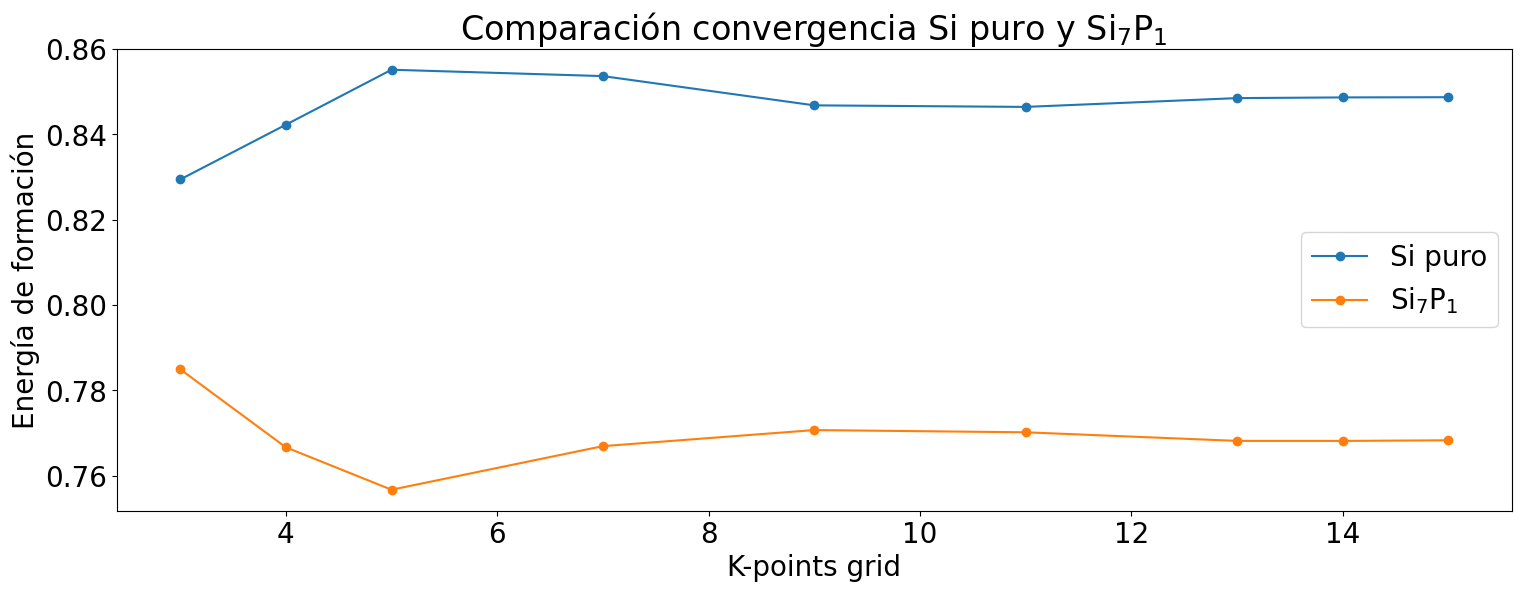

In [30]:
plt.plot(kpoints, Ekpt['pure']-3, '-o', label = 'Si puro')
plt.plot(kpoints, E_for, '-o', label = 'Si$_7$P$_1$')
plt.ylabel('Energía de formación')
plt.xlabel('K-points grid')
plt.title('Comparación convergencia Si puro y Si$_7$P$_1$')
plt.legend()

**Conclusión:** Hay convergencia a partir de $K = 11$. Deberé tomar grillado de $11*11*11$.

***En última instancia***, cambiar a $K = 13$, que parece ser mejor, ***pero*** aumentará mucho el tiempo de cálculo.

In [31]:
KPT = 11

# Cutoff convergence

Defino diferentes valores de energía cinética de corte. Se buscará a partir de cuál el cálculo converge.

In [32]:
ecuts = [200, 250, 300, 350, 400, 450, 500, 600] # Energías cinéticas de corte (como la que habíamos usado de 300 eV arriba).
Ecutoff = {} # Guardaré, para cada estructura (name), la información de las energías de corte en un diccionario

Igual que antes, usamos archivos para evitar recalcular todo.

In [33]:
calcsdir = 'calcs_ecut'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [34]:
for case in structures:
    name, struc, latpar = case
    Ecutoff[name] = np.array([])
    progress = tqdm(ecuts)
    for ecut in progress:
        filename = os.path.join(calcsdir, f'{name}_{ecut}.gpaw')
        logfilename = os.path.join(calcsdir, f'{name}_{ecut}.txt')
        # Energía cinética de corte "ecut" eV. Divido celda en grilla de "KPT*KPT*KPT".
        calc = load_calc(filename, mode=PW(ecut), txt=logfilename, xc='PBE', kpts=[KPT,KPT,KPT])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(filename)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Imprimo energías potenciales calculadas para **Si puro** y **Si7P1**, en función de las energías de corte consideradas en el cálculo.

In [35]:
Ecutoff

{'pure': array([3.85598245, 3.84828234, 3.84643687, 3.84514617, 3.84383355,
        3.84336176, 3.84310033, 3.84278573]),
 'wPhos': array([3.47354362, 3.46234613, 3.45954958, 3.45795791, 3.45660652,
        3.45606584, 3.45569827, 3.45522086])}

***Convergencia del Si7P1:*** Se calculó su energía de formación $\Delta E_f$, siguiendo la expresión:

$$ \Delta E_f = \frac{E_{Si7P1}}{N} - \frac{1}{N} \left( n_{Si} E_{Si} + n_{P} E_{P} \right) $$

- $N = 8$, es la variable **N_Si_P** con el número de átomos de la estructura del compuesto.
- $n_{P} = 1$, por lo que $n_{Si} = 7$.
- Del diccionario **Ecutoff**, se tomaron $E_{Si}$ [eV/át] y $\frac{E_{Si7P1}}{N}$ [eV/át].
- Se empleó $E_P = -5,435\ eV/at$, que se extrajo de bibliografía considerando una energía de corte de 600 eV (porque es la más alta que consideré en las estimaciones).

***Convergencia del Si puro:*** Al tratarse de un elemento puro, no tiene energía de formación. Se emplearán las energías potenciales en **Ecutoff**.

In [36]:
n_Si = 7
n_P = 1
E_P = -5.435

In [37]:
vec_cutoff_conv = np.arange(0,len(Ecutoff['pure']))
E_for = []
for i in vec_cutoff_conv:
  E_for = np.append(E_for, Ecutoff['wPhos'][i] - (1/N_Si_P)*(n_Si*Ecutoff['pure'][i] + n_P*E_P))
print(E_for)

[0.77893397 0.77447409 0.77329232 0.77283001 0.77262717 0.7724993
 0.77236049 0.77215834]


(!!!) **Importante:** Para ***facilitar la comparación*** de las energías de formación, se restaron $3\ eV$ a las energías del Si puro.

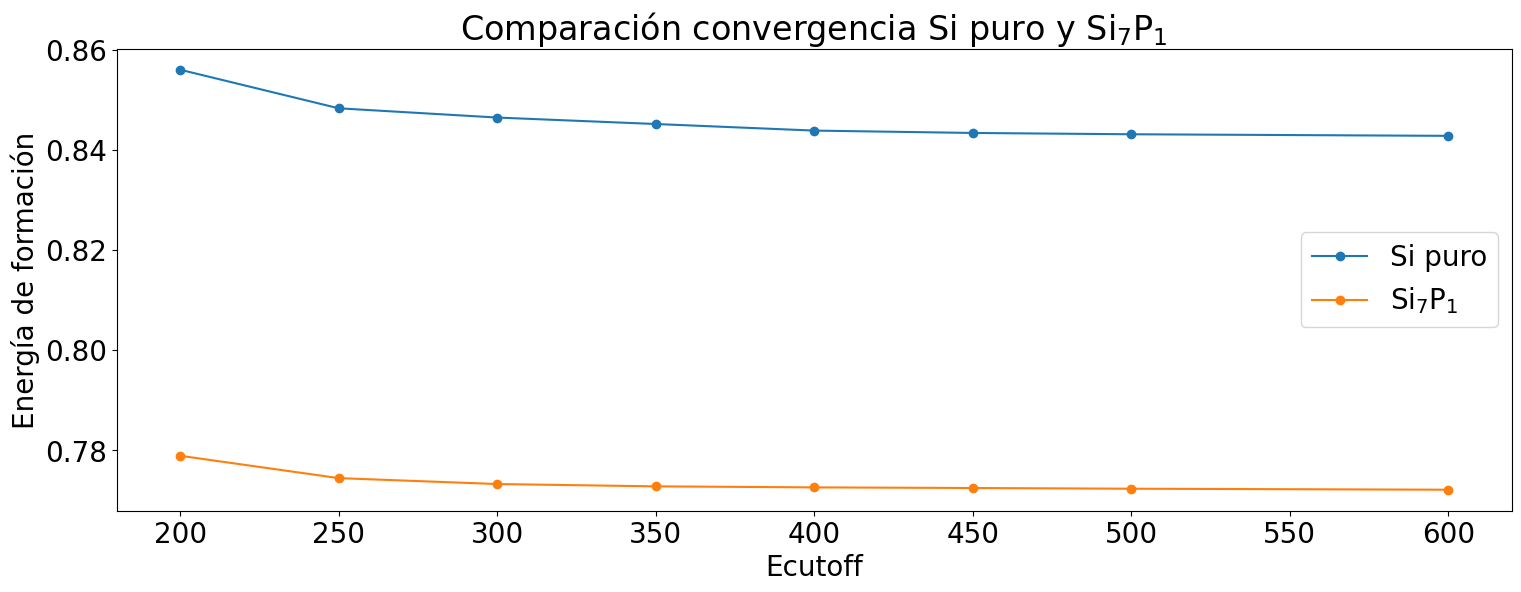

In [38]:
plt.plot(ecuts, Ecutoff['pure']-3, '-o', label = 'Si puro')
plt.plot(ecuts, E_for, '-o', label = 'Si$_7$P$_1$')
plt.ylabel('Energía de formación')
plt.xlabel('Ecutoff')
plt.title('Comparación convergencia Si puro y Si$_7$P$_1$')
plt.legend()

**Conclusión:** Hay convergencia a partir de $E = 350$. Debería tomar energía cinética de corte $ECUT = 350$, ***pero en su lugar tomaré*** $ECUT = 450$ porque en la comparación entre Si puro y Si7B1 utilicé dicho valor.

***En algún momento***, probar si cambian mucho los resultados al emplear $ECUT = 350$, asumo que lo que hará será disminuir el tiempo de cálculo a lo sumo.

In [39]:
ECUT = 450

# Lattice Parameter

In [40]:
structures

[('pure',
  Atoms(symbols='Si8', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  5.5),
 ('wPhos',
  Atoms(symbols='PSi7', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  5.65)]

Igual que antes, usamos archivos para evitar recalcular todo.

In [41]:
latparcalcs = 'calcs_latpar'

In [42]:
if not os.path.exists(latparcalcs):
    os.makedirs(latparcalcs)

In [43]:
import ase, gpaw
def doevcurve(name: str, struc: ase.atoms.Atoms, sizes: np.ndarray, gpaw_kwargs:dict):
    """
    name: str con el nombre de la estructura
    struc: atoms object con la estructura a calcular
    sizes: np.ndarray con los parametros de red para esta estructura
    gpaw_kwargs: opciones para gpaw
    """
    E = []
    V = []
    progress = tqdm(sizes)
    for latpar in progress:
        gpawfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.gpaw')
        logfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.txt')
        gpaw_kwargs.update({'txt': logfile})
        calc = load_calc(gpawfile, **gpaw_kwargs)
        struc.set_cell(latpar*np.eye(3), scale_atoms=True) # ojo, esto vale solo para cubicas !
        struc.set_calculator(calc)
        V.append(struc.get_volume())
        E.append(struc.get_potential_energy())
        struc.calc.write(gpawfile)
    return {'V': V, 'E': E}
        
        

In [44]:
GPAW_KWARGS = dict(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT])

In [45]:
evcurves={}

In [46]:
for case in structures:
    name, struc, guess = case
    print(guess)
    # Se había supuesto "a=guess", pero ahora se supondrán 10 valores de "a" en un entorno de "guess", para obtener el más óptimo.
    latparams = np.linspace(guess*0.95, guess*1.05, 10)
    evcurves[name] = doevcurve(name,struc, latparams, GPAW_KWARGS)

5.5


  0%|          | 0/10 [00:00<?, ?it/s]

5.65


  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Comparación curvas E(por átomo) vs. V, de Si puro y Si$_7$P$_1$')

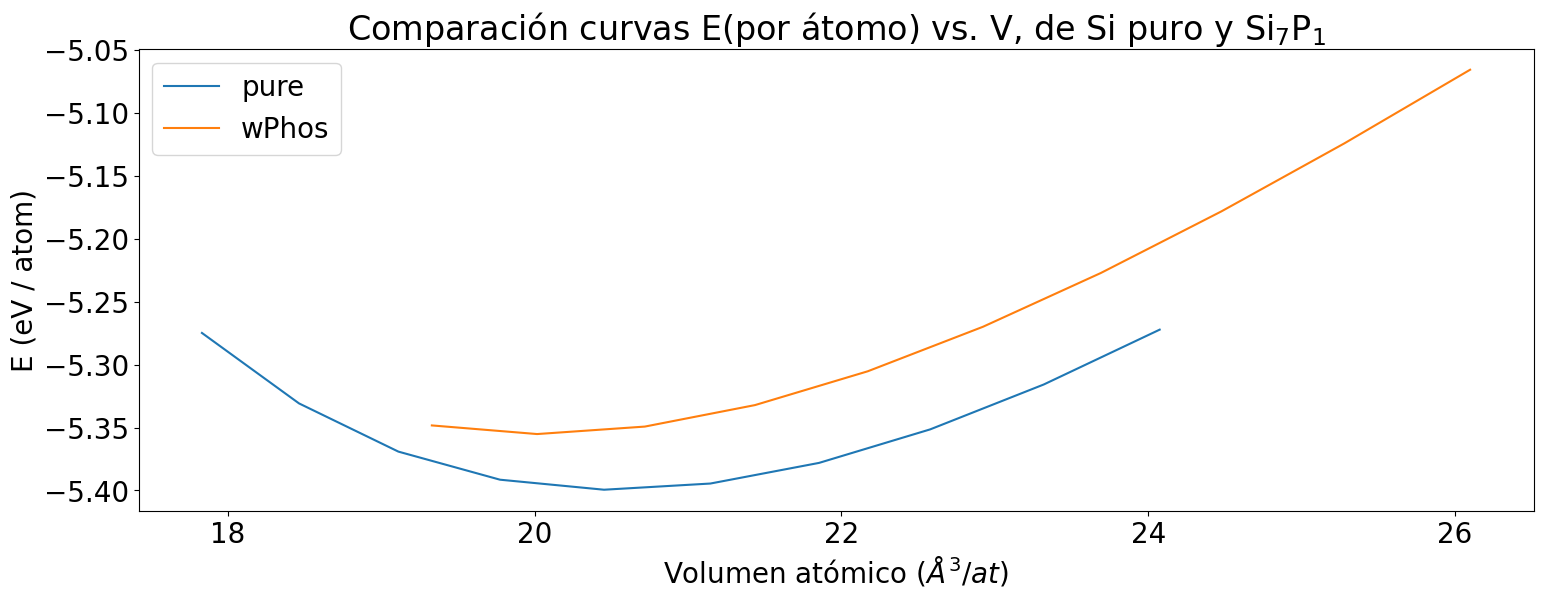

In [47]:
for (name, evcurve), case in zip(evcurves.items(), structures):
    structure = case[1]
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('Volumen atómico ($\AA ^3 / at $)')
ylabel = plt.ylabel('E (eV / atom)')
plt.title('Comparación curvas E(por átomo) vs. V, de Si puro y Si$_7$P$_1$')

En el gráfico se representó la Energía dividida por el número de átomos que componen al compuesto ($E / N$), para que las energías sean comparables.

Podría buscar el volumen $V$ para el cual la energía es mínima ($E_{min}$), aplicarle raiz cúbica y obtener el parámetro de red $a$ óptimo. Sin embargo, no se recomienda y en su lugar conviene hacerlo realizando un ajuste con la **ecuación de estado**, lo que haremos a continuación.

# Ecuación de Estado 

Se realizará un *ajuste de la Energía vs. Volumen de celda*, empleando la **ecuación de estado de Birch-Murnaghan**.

## **Si puro**

In [48]:
eos_Si_puro = EquationOfState(evcurves['pure']['V'],evcurves['pure']['E'],eos='birchmurnaghan')

In [49]:
eos_Si_puro.fit()

(164.1648044460769, -43.19552566832418, 0.550273727341909)

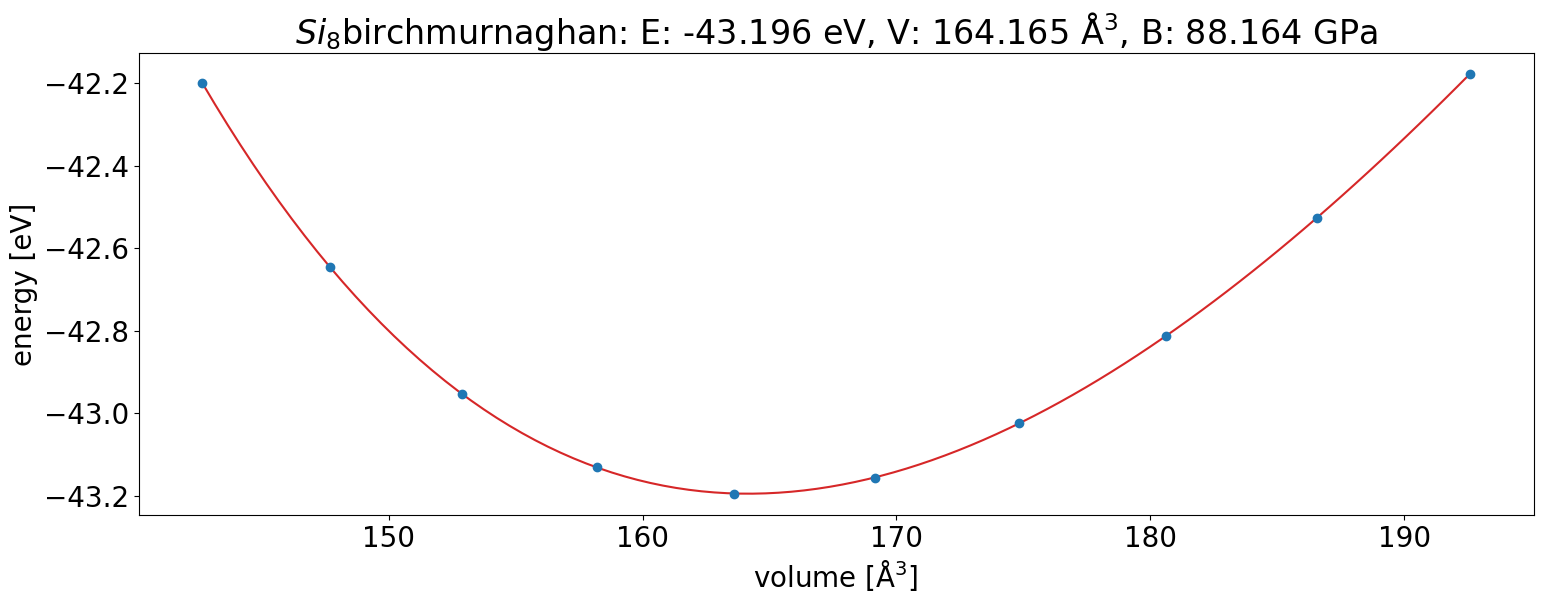

In [50]:
ax = eos_Si_puro.plot()
title = ax.get_title()
newtitle = ax.set_title('$Si_8$' + title)

Energía mínima.

In [51]:
E_Si_puro = eos_Si_puro.fit()[1]
print(E_Si_puro)

-43.19552566832418


Volumen que minimiza la energía.

In [52]:
V_Si_puro = eos_Si_puro.fit()[0]
print(V_Si_puro)

164.1648044460769


Parámetro de red que minimiza la energía (**parámetro de red en equilibrio**).

**Conclusión:** Se acercó mucho al estimado inicialmente.

In [53]:
a_Si_puro = V_Si_puro**(1/3)
print(a_Si_puro)

5.475536578657841


## **Si7P1**

In [54]:
eos_Si_P = EquationOfState(evcurves['wPhos']['V'],evcurves['wPhos']['E'],eos='birchmurnaghan')

In [55]:
eos_Si_P.fit()

(160.22786322073, -42.84236496941143, 0.5356773742380497)

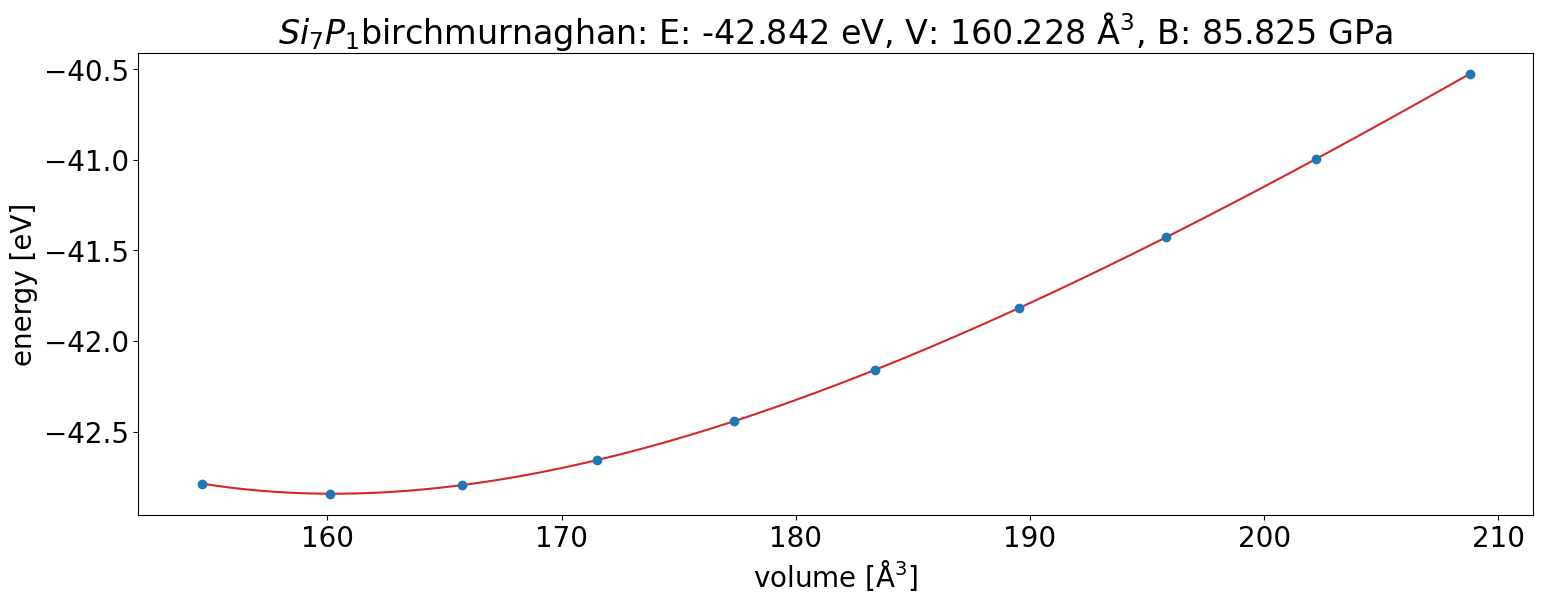

In [56]:
ax = eos_Si_P.plot()
title = ax.get_title()
newtitle = ax.set_title('$Si_7 P_1$' + title)

Energía mínima.

In [57]:
E_Si_P = eos_Si_P.fit()[1]
print(E_Si_P)

-42.84236496941143


Volumen que minimiza la energía.

In [58]:
V_Si_P = eos_Si_P.fit()[0]
print(V_Si_P)

160.22786322073


Parámetro de red que minimiza la energía (**parámetro de red en equilibrio**).

In [59]:
a_Si_P = V_Si_P**(1/3)
print(a_Si_P)

5.431411160497274


**Conclusión:** Al dopar **Si puro** con 1 átomo de P, se observó:
- Reducción del parámetro de red, de 5,476 Å a 5,431 Å.
- Aumento de la energía del compuesto, de -43,195 eV a -42,842 eV.

# Densidad de Estados 

Se vuelven a definir las estructuras a considerar, pero esta vez empleando los parámetros previamente calculados correspondientes al estado de equilibrio. 

En pruebas anteriores, donde se empleó el valor de KPT que había convergido al inicio, los gráficos de la densidad de estados se observaban puntiagudos. Para suavizarlos, se redefinió $KPT = 31$, sólo por fines estéticos.

In [60]:
KPT = 31

## **Si puro**

In [61]:
eq_SiDiamond = bulk('Si','diamond', a=a_Si_puro, cubic=True)

In [62]:
printatoms = [print(at) for at in eq_SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3688841446644602, 1.3688841446644602, 1.3688841446644602], index=1)
Atom('Si', [0.0, 2.7377682893289204, 2.7377682893289204], index=2)
Atom('Si', [1.3688841446644602, 4.10665243399338, 4.10665243399338], index=3)
Atom('Si', [2.7377682893289204, 0.0, 2.7377682893289204], index=4)
Atom('Si', [4.10665243399338, 1.3688841446644602, 4.10665243399338], index=5)
Atom('Si', [2.7377682893289204, 2.7377682893289204, 0.0], index=6)
Atom('Si', [4.10665243399338, 4.10665243399338, 1.3688841446644602], index=7)


In [63]:
# calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiDiamond.txt')
calc = load_calc('eq_SiDiamond.gpw', mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiDiamond.txt')
eq_SiDiamond.set_calculator(calc)
eq_SiDiamond.get_potential_energy()

-43.19616771973655

(!!!) **Observación:** No me dio igual que antes, me daba -43.1955, ¿es normal que esto suceda?

In [64]:
e_SiDiamond,dos_SiDiamond = eq_SiDiamond.calc.get_dos(npts=500)
ef_SiDiamond = eq_SiDiamond.calc.get_fermi_level()

Text(0.5, 1.0, 'Densidad de estados - Si puro')

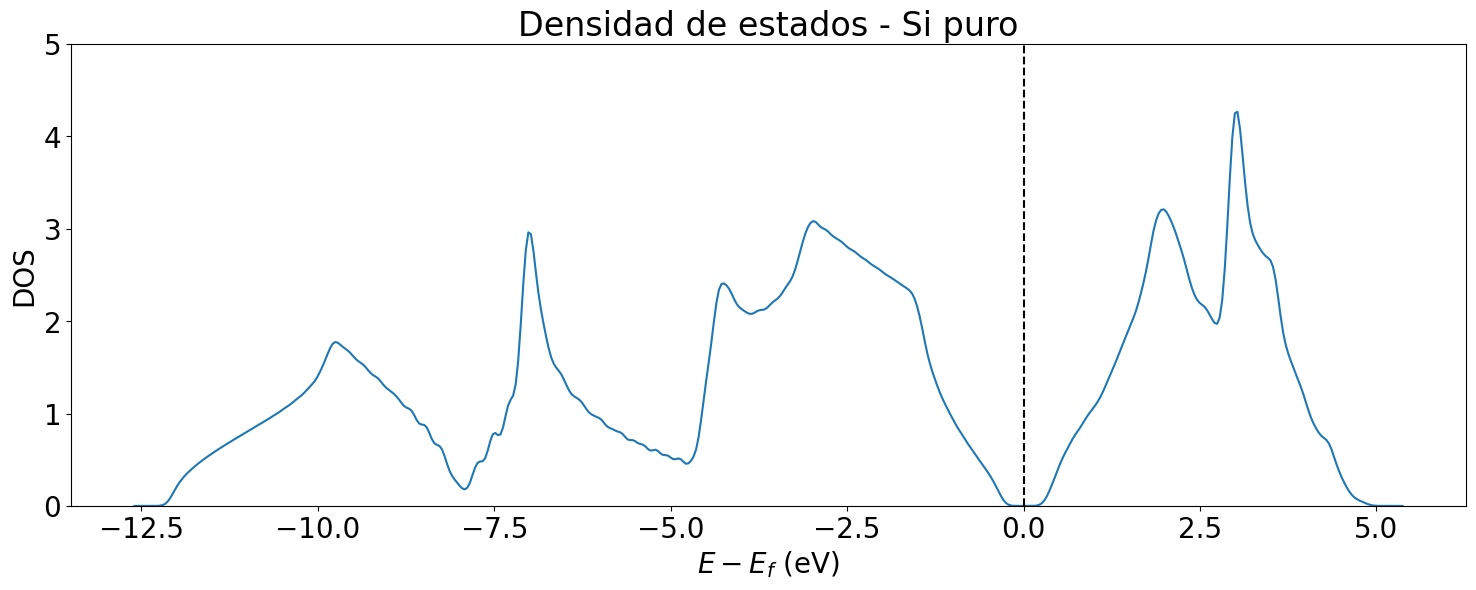

In [65]:
plt.plot(e_SiDiamond - ef_SiDiamond, dos_SiDiamond)
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Densidad de estados - Si puro')

**Conclusión:** A la energía de Fermi no se encuentran estados disponibles para la conducción eléctrica, por lo que el **Si puro** se comporta como aislante eléctrico.

In [66]:
eq_SiDiamond.calc.write('eq_SiDiamond.gpw')

In [67]:
bscalc_SiDiamond = GPAW('eq_SiDiamond.gpw').fixed_density(nbands=30, symmetry='off', txt='bs_SiDiamond.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [68]:
bs_SiDiamond = bscalc_SiDiamond.band_structure()

In [69]:
bs_SiDiamond = bs_SiDiamond.subtract_reference()

Text(0.5, 1.0, 'Estructura de bandas - Si puro')

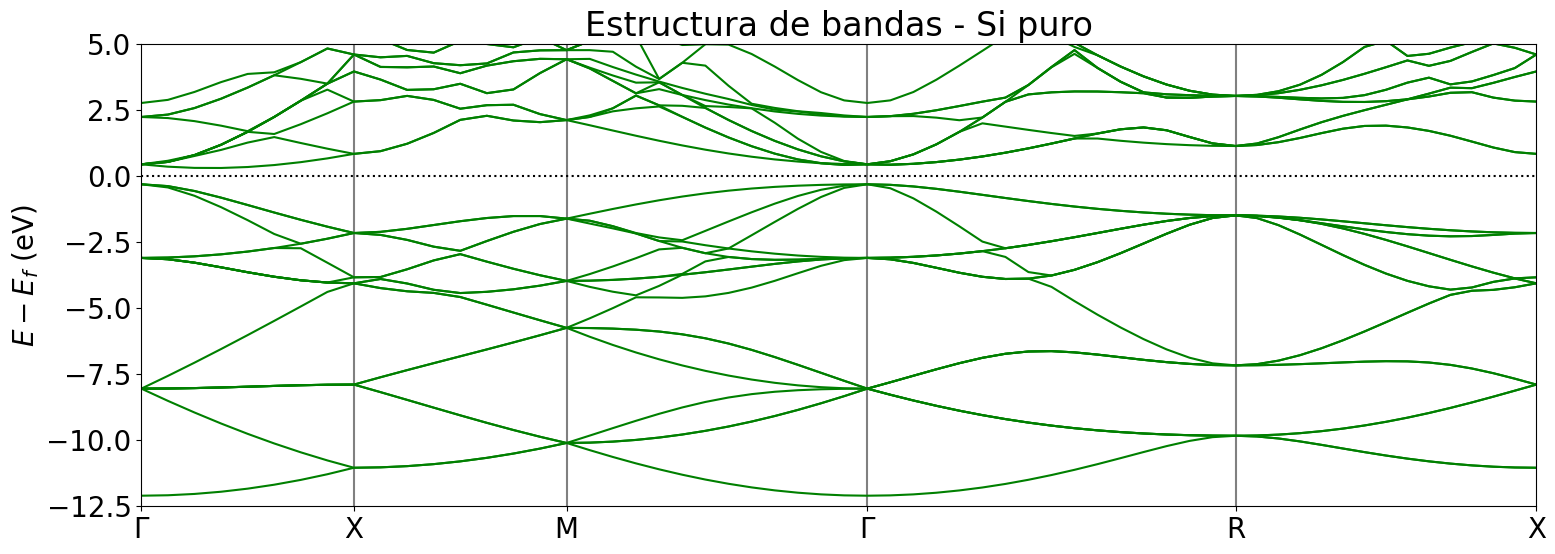

In [70]:
ax = bs_SiDiamond.plot(emin=-12.5, emax=5)
ax.set_ylabel('$E-E_f$ (eV)')
ax.set_title('Estructura de bandas - Si puro')

**Conclusión:** Tal como se observó en el gráfico de la densidad de estados, a la energía de Fermi no se encuentran estados disponibles para la conducción eléctrica, por lo que el **Si puro** se comporta como aislante eléctrico.

## **Si7P1**

In [71]:
# La defino sin dopar.
eq_SiPDiamond = bulk('Si','diamond', a=a_Si_P, cubic=True)

In [72]:
# Creo lista normal, con los elementos de la original "eq_SiPDiamond".
eq_SiPDiamondList = [at for at in eq_SiPDiamond]
# Con "atom" defino el átomo de P, le asigno posición que tenía el Si en "eq_SiPDiamond", y guardo en la lista "eq_SiPDiamondList".
eq_SiPDiamondList[0] = Atom('P', position=eq_SiPDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "eq_SiPDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir
# de lo que contiene "eq_SiPDiamondList".
eq_SiPDiamond = Atoms(eq_SiPDiamondList, cell=eq_SiPDiamond.cell, pbc=True)

In [73]:
print_new_atoms = [print(at) for at in eq_SiPDiamond]

Atom('P', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3578527901243185, 1.3578527901243185, 1.3578527901243185], index=1)
Atom('Si', [0.0, 2.715705580248637, 2.715705580248637], index=2)
Atom('Si', [1.3578527901243185, 4.073558370372956, 4.073558370372956], index=3)
Atom('Si', [2.715705580248637, 0.0, 2.715705580248637], index=4)
Atom('Si', [4.073558370372956, 1.3578527901243185, 4.073558370372956], index=5)
Atom('Si', [2.715705580248637, 2.715705580248637, 0.0], index=6)
Atom('Si', [4.073558370372956, 4.073558370372956, 1.3578527901243185], index=7)


In [74]:
# calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiPDiamond.txt')
calc = load_calc('eq_SiPDiamond.gpw', mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiPDiamond.txt')
eq_SiPDiamond.set_calculator(calc)
eq_SiPDiamond.get_potential_energy()

-42.840847679414956

(!!!) **Observación:** No me dio igual que antes, me daba -42.8424, ¿es normal que esto suceda?

In [75]:
e_SiPDiamond,dos_SiPDiamond = eq_SiPDiamond.calc.get_dos(npts=500)
ef_SiPDiamond = eq_SiPDiamond.calc.get_fermi_level()

Text(0.5, 1.0, 'Densidad de estados - Si$_7$P$_1$')

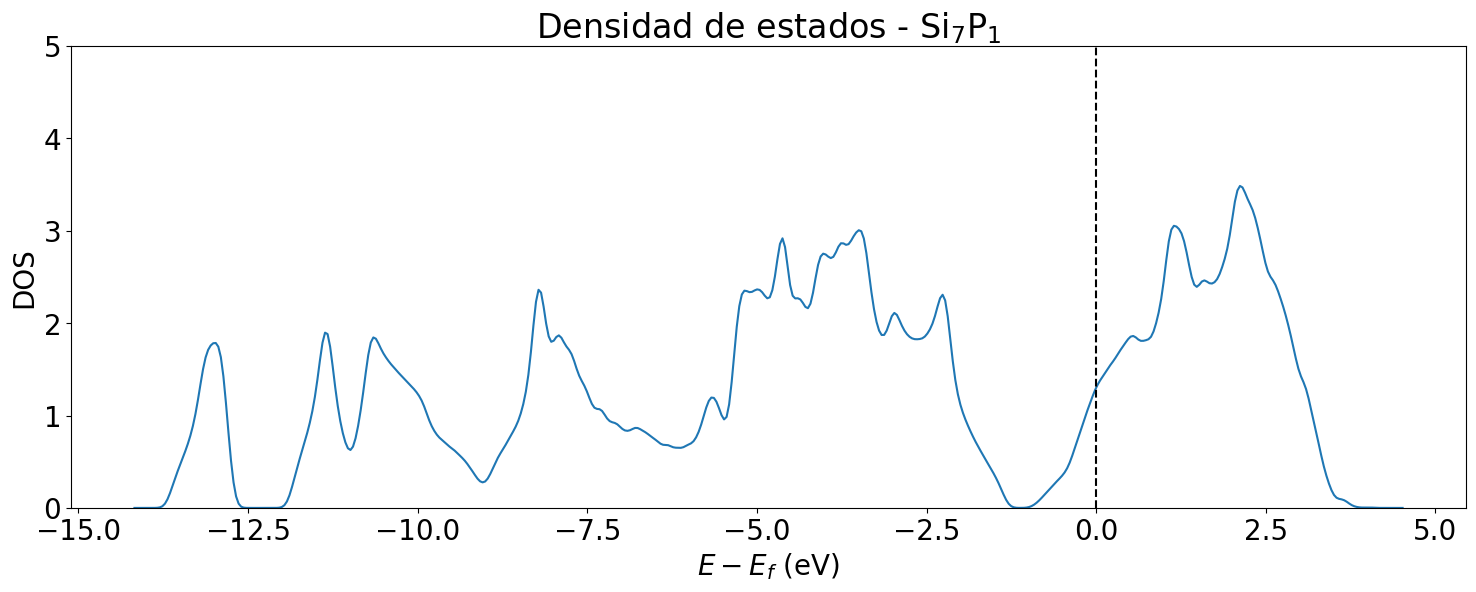

In [76]:
plt.plot(e_SiPDiamond - ef_SiPDiamond,dos_SiPDiamond)
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Densidad de estados - Si$_7$P$_1$')

Se observa que los estados que permiten la conducción por electrones se han desplazado hacia menores energías, de tal manera que algunos de ellos poseen la energía de Fermi. Esto no ocurría en el caso del Si puro.

**Conclusión:** A la energía de Fermi hay estados disponibles para la conducción eléctrica, por lo que el **Si7P1** se comporta como conductor eléctrico.

In [77]:
eq_SiPDiamond.calc.write('eq_SiPDiamond.gpw')

In [78]:
bscalc_SiPDiamond = GPAW('eq_SiPDiamond.gpw').fixed_density(nbands=30, symmetry='off', txt='bs_SiPDiamond.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [79]:
bs_SiPDiamond = bscalc_SiPDiamond.band_structure()

In [80]:
bs_SiPDiamond = bs_SiPDiamond.subtract_reference()

Text(0.5, 1.0, 'Estructura de bandas - Si$_7$P$_1$')

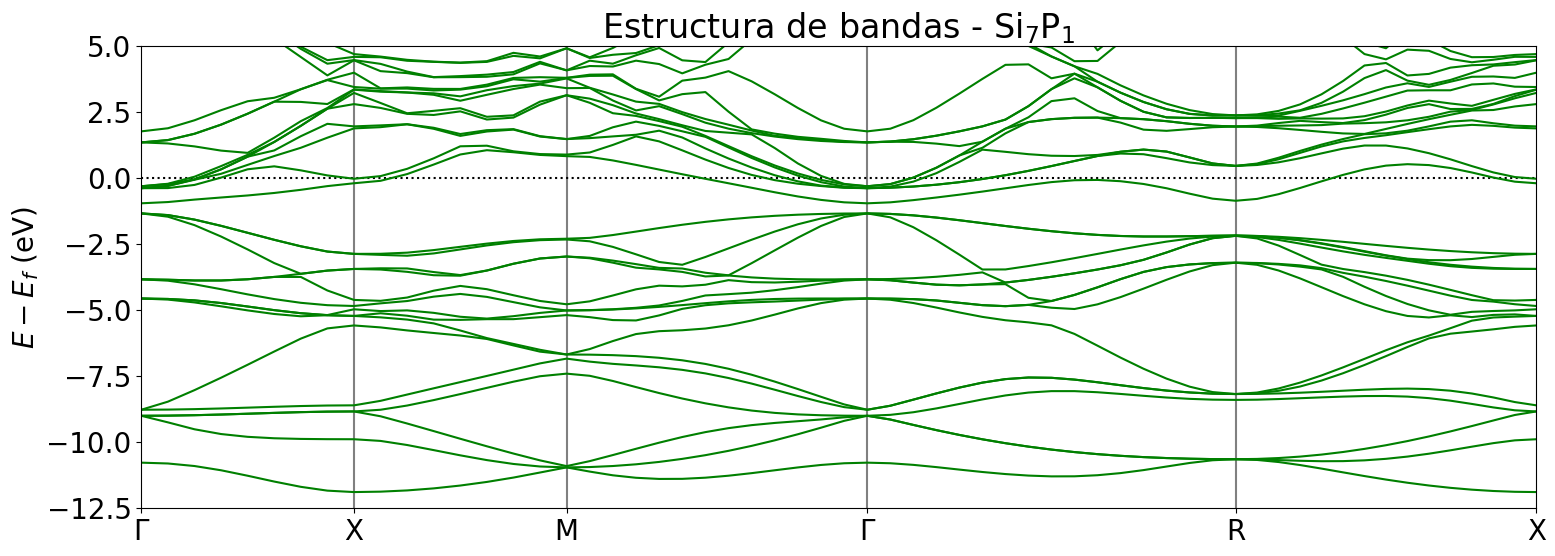

In [81]:
ax = bs_SiPDiamond.plot(emin=-12.5, emax=5)
ax.set_ylabel('$E-E_f$ (eV)')
ax.set_title('Estructura de bandas - Si$_7$P$_1$')

**Conclusión:** Tal como se observó en el gráfico de la densidad de estados, a la energía de Fermi hay estados  disponibles para la conducción eléctrica por electrones, por lo que el **Si7P1 (Si dopado)** se comporta como conductor eléctrico.

# Densidad de estados - Superceldas

Se considerará la estructura de equilibrio del Si puro y con ella se definirá una **supercelda de Si puro**, con el objetivo de introducir un átomo de P en ella y que este defecto esté diluido debido a la gran cantidad de átomos de Si que posee la estructura.

**Se espera** que esta dilución provoque que la energía de Fermi se desplace levemente hacia estados capaces de conducir electricidad por huecos, en lugar del gran desplazamiento observado cuando se empleó una celda de tan solo 7 átomos de Si y 1 átomo de P. 

In [82]:
printatoms = [print(at) for at in eq_SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3688841446644602, 1.3688841446644602, 1.3688841446644602], index=1)
Atom('Si', [0.0, 2.7377682893289204, 2.7377682893289204], index=2)
Atom('Si', [1.3688841446644602, 4.10665243399338, 4.10665243399338], index=3)
Atom('Si', [2.7377682893289204, 0.0, 2.7377682893289204], index=4)
Atom('Si', [4.10665243399338, 1.3688841446644602, 4.10665243399338], index=5)
Atom('Si', [2.7377682893289204, 2.7377682893289204, 0.0], index=6)
Atom('Si', [4.10665243399338, 4.10665243399338, 1.3688841446644602], index=7)


In [83]:
from ase.build import make_supercell

In [84]:
sc_SiDiamond2x2x2 = make_supercell(eq_SiDiamond, [[2,0,0], [0,2,0],[0,0,2]])

Aprovechando el hecho de que el defecto sustitucional está diluido en la estructura, podemos tomar la supercelda y reemplazar 1 átomo de Si por uno de P ***sin la necesidad*** de calcular el parámetro de red de equilibrio que supone la introducción de este defecto. La supercelda "dopada" tendrá el mismo parámetro de red que la misma sin dopar.

In [85]:
# Creo lista normal, con los elementos de la original "sc_SiDiamond2x2x2".
sc_SiDiamond2x2x2List = [at for at in sc_SiDiamond2x2x2]
# Con "atom" defino el átomo de P, le asigno posición que tenía el Si en "sc_SiDiamond2x2x2", y guardo en la lista "sc_SiDiamond2x2x2List".
sc_SiDiamond2x2x2List[0]=Atom('P', position=sc_SiDiamond2x2x2[0].position)
# Con "atoms", defino la celda (igual a la de "sc_SiDiamond2x2x2", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir de
# lo que contiene "sc_SiDiamond2x2x2List".
sc_SiPDiamond2x2x2=Atoms(sc_SiDiamond2x2x2List, cell=sc_SiDiamond2x2x2.cell, pbc=True)

In [86]:
print_new_atoms = [print(at) for at in sc_SiPDiamond2x2x2]

Atom('P', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3688841446644602, 1.3688841446644602, 1.3688841446644602], index=1)
Atom('Si', [0.0, 2.7377682893289204, 2.7377682893289204], index=2)
Atom('Si', [1.3688841446644602, 4.10665243399338, 4.10665243399338], index=3)
Atom('Si', [2.7377682893289204, 0.0, 2.7377682893289204], index=4)
Atom('Si', [4.10665243399338, 1.3688841446644602, 4.10665243399338], index=5)
Atom('Si', [2.7377682893289204, 2.7377682893289204, 0.0], index=6)
Atom('Si', [4.10665243399338, 4.10665243399338, 1.3688841446644602], index=7)
Atom('Si', [0.0, 0.0, 5.47553657865784], index=8)
Atom('Si', [1.3688841446644602, 1.3688841446644602, 6.844420723322301], index=9)
Atom('Si', [0.0, 2.7377682893289204, 8.21330486798676], index=10)
Atom('Si', [1.3688841446644602, 4.10665243399338, 9.58218901265122], index=11)
Atom('Si', [2.7377682893289204, 0.0, 8.21330486798676], index=12)
Atom('Si', [4.10665243399338, 1.3688841446644602, 9.58218901265122], index=13)
Atom('Si', [2.737768289328

Se me acaba la RAM si uso KPT = 31, probaré si me deja calcular algo usando KPT = 11.

In [87]:
KPT = 11

In [88]:
calc = load_calc('sc_SiPDiamond2x2x2.gpw', mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='sc_SiPDiamond2x2x2.txt')
sc_SiPDiamond2x2x2.set_calculator(calc)
sc_SiPDiamond2x2x2.get_potential_energy()

-345.233318928871

In [89]:
e_sc_SiPDiamond2x2x2,dos_sc_SiPDiamond2x2x2 = sc_SiPDiamond2x2x2.calc.get_dos(npts=500)
ef_sc_SiPDiamond2x2x2 = sc_SiPDiamond2x2x2.calc.get_fermi_level()

Text(0.5, 1.0, 'Densidad de estados - Supercelda Si$_{63}$P$_1$')

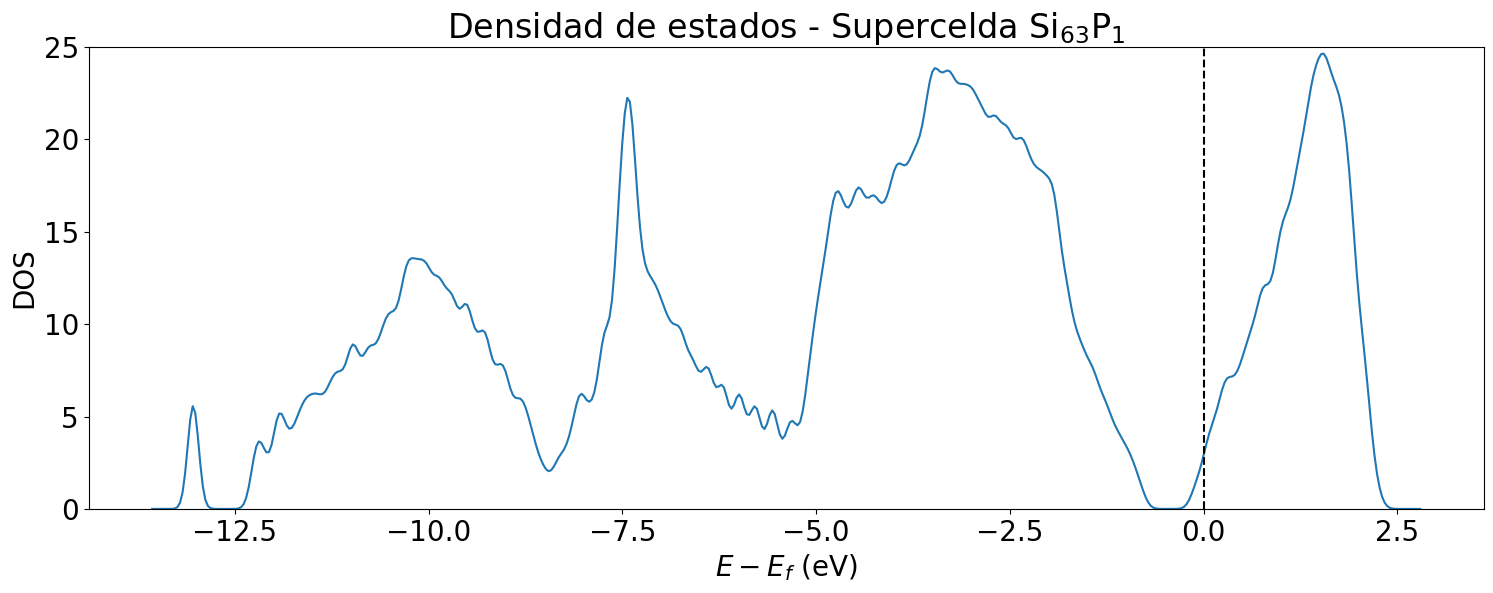

In [90]:
plt.plot(e_sc_SiPDiamond2x2x2 - ef_sc_SiPDiamond2x2x2,dos_sc_SiPDiamond2x2x2)
plt.ylim((0, 25))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Densidad de estados - Supercelda Si$_{63}$P$_1$')

In [91]:
sc_SiPDiamond2x2x2.calc.write('sc_SiPDiamond2x2x2.gpw')

No me deja calcular la estructura de bandas, no me da la RAM.

In [92]:
# bscalc_sc_SiPDiamond2x2x2 = GPAW('sc_SiPDiamond2x2x2.gpw').fixed_density(nbands=250, symmetry='off', txt='bs_sc_SiPDiamond2x2x2.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [93]:
# bs_sc_SiPDiamond2x2x2 = bscalc_sc_SiPDiamond2x2x2.band_structure()

In [94]:
# bs_sc_SiPDiamond2x2x2 = bs_sc_SiPDiamond2x2x2.subtract_reference()

In [95]:
# ax = bs_sc_SiPDiamond2x2x2.plot(emin=-12.5, emax=5)
# ax.set_ylabel('$E-E_f$ (eV)')
# ax.set_title('Estructura de bandas - Supercelda Si con 1 átomo de P')

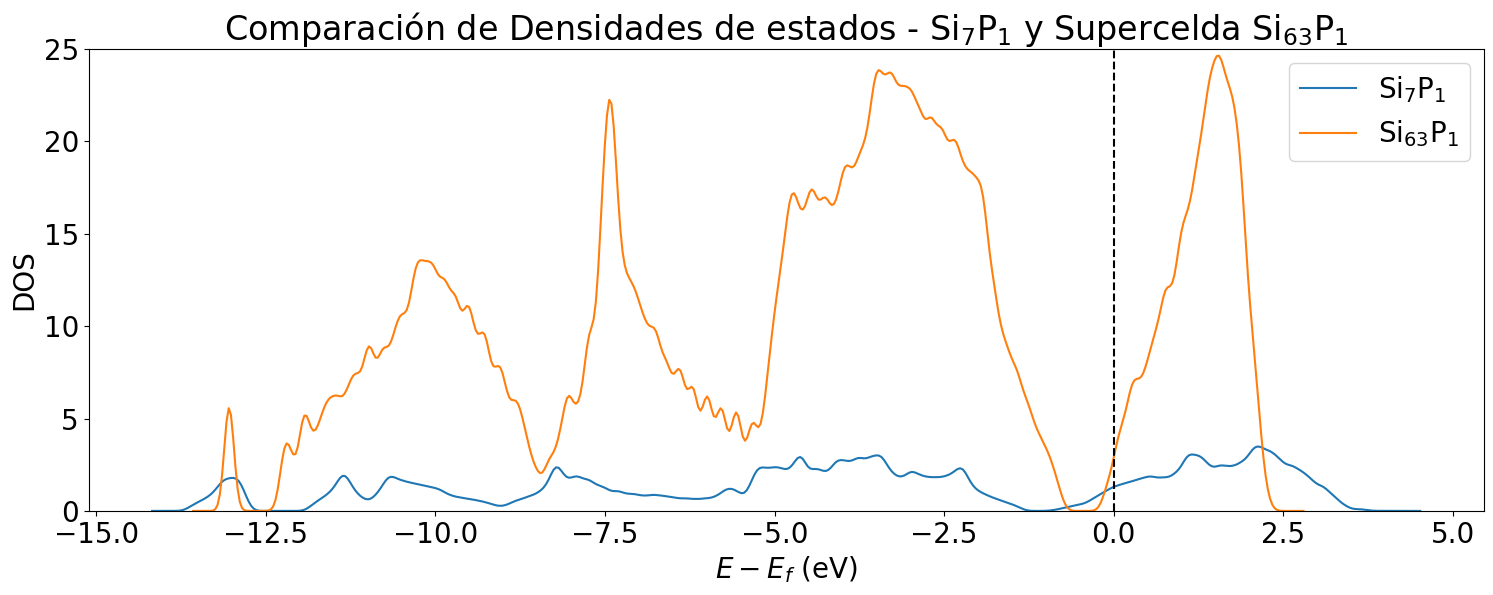

In [96]:
plt.plot(e_SiPDiamond - ef_SiPDiamond, dos_SiPDiamond, label='Si$_{7}$P$_1$')
plt.plot(e_sc_SiPDiamond2x2x2 - ef_sc_SiPDiamond2x2x2,dos_sc_SiPDiamond2x2x2, label='Si$_{63}$P$_1$')
plt.ylim((0, 25))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Comparación de Densidades de estados - Si$_{7}$P$_1$ y Supercelda Si$_{63}$P$_1$')
plt.legend()

**Efectivamente**, se nota que la energía de Fermi se ha desplazado menos respecto del gap, en comparación con $Si_7 P_1$.

Haremos un mejor gráfico para comparar.

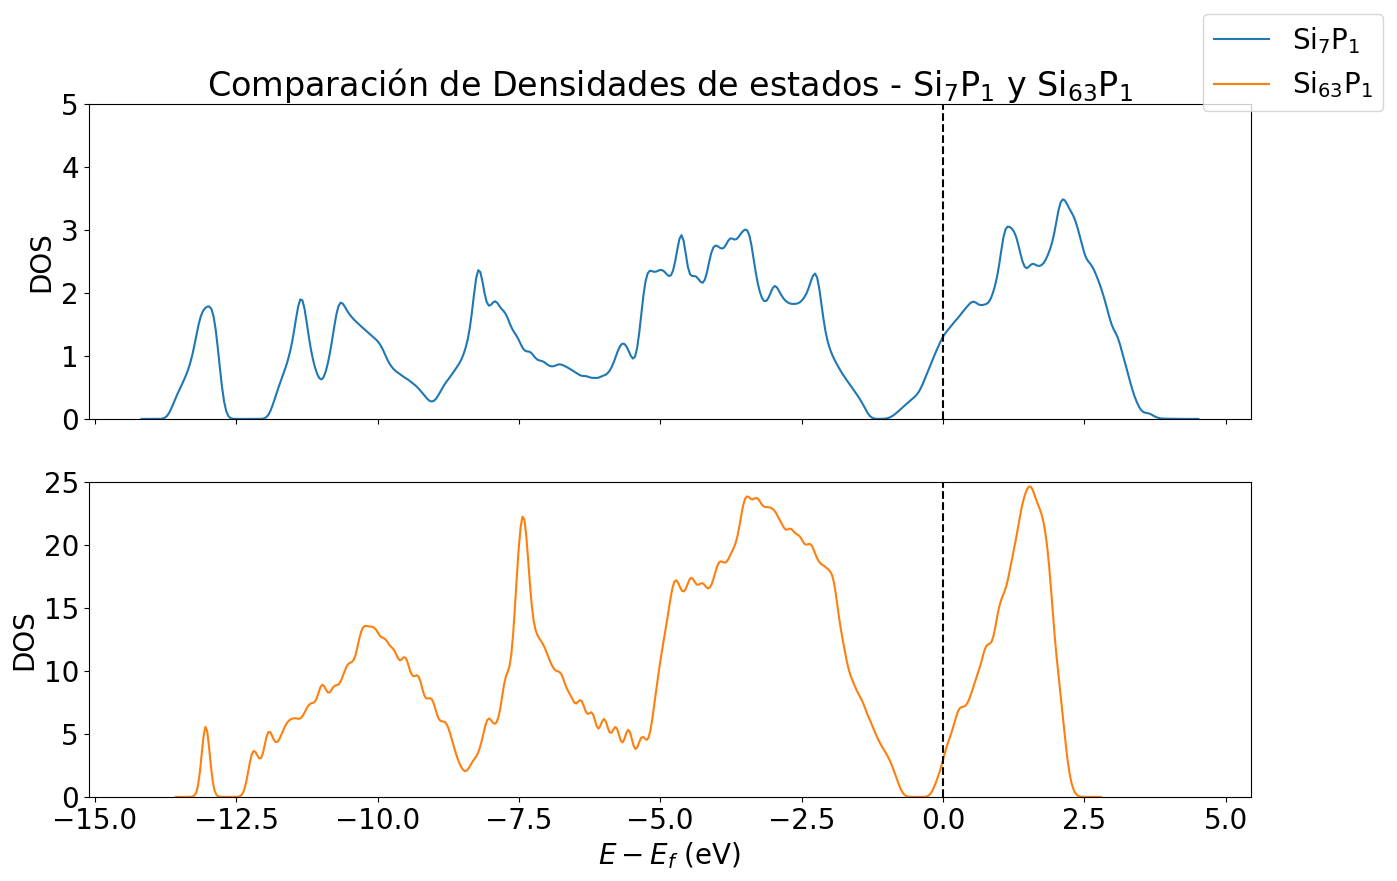

In [97]:
fig, ax = plt.subplots(2,1, figsize=(15,9), sharex=True)
ax[0].plot(e_SiPDiamond - ef_SiPDiamond, dos_SiPDiamond, label='Si$_{7}$P$_1$')
ax[1].plot(e_sc_SiPDiamond2x2x2 - ef_sc_SiPDiamond2x2x2,dos_sc_SiPDiamond2x2x2, 'C1', label='Si$_{63}$P$_1$')
ax[0].set_ylim((0, 5))
ax[1].set_ylim((0, 25))
for i in range(2):
  ax[i].set_ylabel('DOS')
  ax[i].axvline(color='k', linestyle='--')
ax[1].set_xlabel('$E - E_f$ (eV)')
ax[0].set_title('Comparación de Densidades de estados - Si$_{7}$P$_1$ y Si$_{63}$P$_1$')
fig.legend()

**Sugerencia de Rubén:** Dividir la DOS por el número de átomos de la estructura, para ver si los gráficos salen más comparables.

In [98]:
sc_SiPDiamond2x2x2.get_global_number_of_atoms()

64

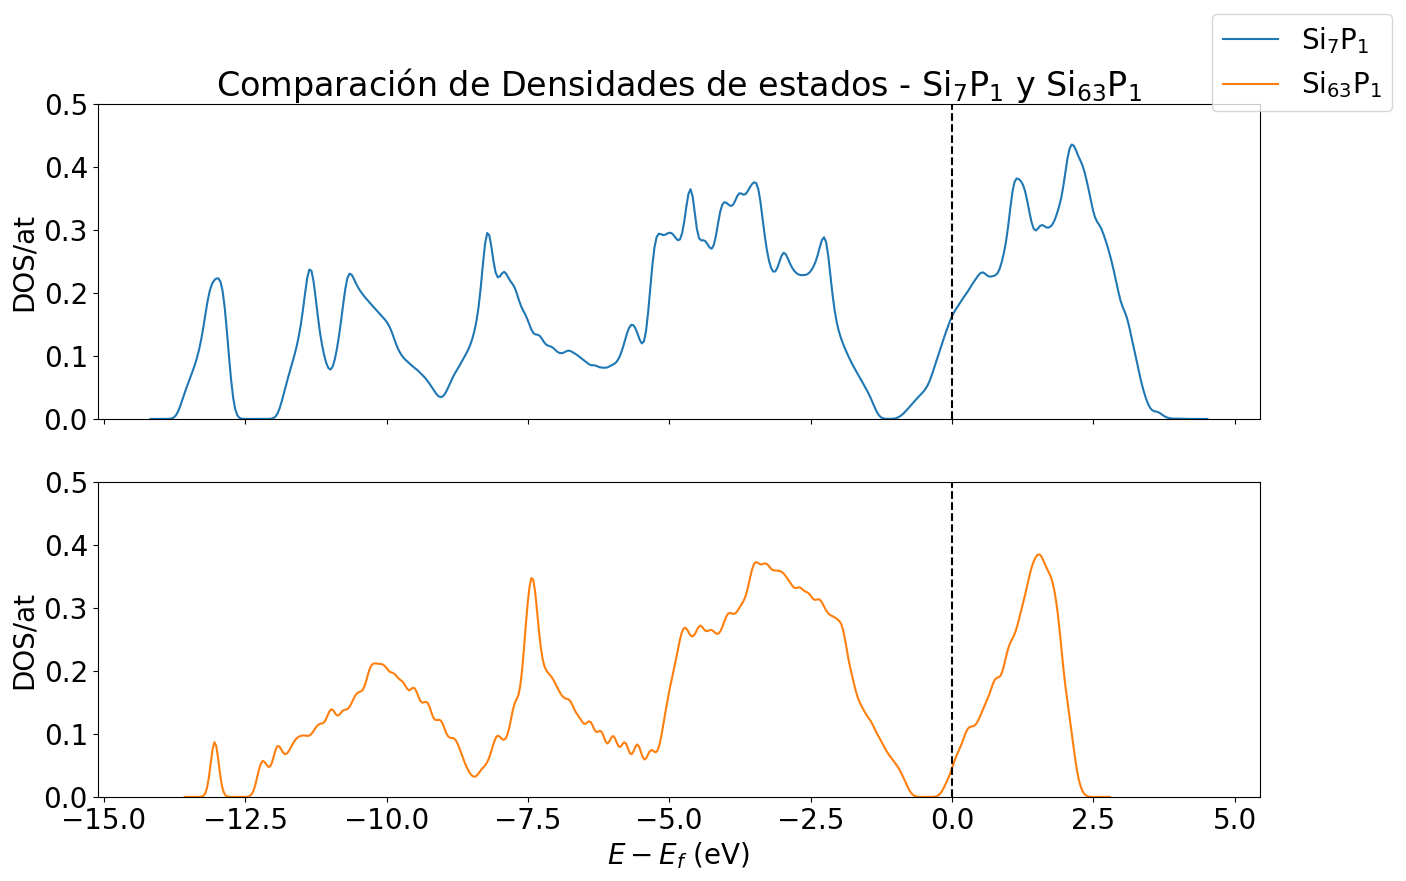

In [101]:
fig, ax = plt.subplots(2,1, figsize=(15,9), sharex=True)
ax[0].plot(e_SiPDiamond - ef_SiPDiamond, dos_SiPDiamond/SiPDiamond.get_global_number_of_atoms(), label='Si$_{7}$P$_1$')
ax[1].plot(e_sc_SiPDiamond2x2x2 - ef_sc_SiPDiamond2x2x2,dos_sc_SiPDiamond2x2x2/sc_SiPDiamond2x2x2.get_global_number_of_atoms(), 'C1', label='Si$_{63}$P$_1$')
ax[0].set_ylim((0, 0.5))
ax[1].set_ylim((0, 0.5))
for i in range(2):
  ax[i].set_ylabel('DOS/at')
  ax[i].axvline(color='k', linestyle='--')
ax[1].set_xlabel('$E - E_f$ (eV)')
ax[0].set_title('Comparación de Densidades de estados - Si$_{7}$P$_1$ y Si$_{63}$P$_1$')
fig.legend()

Era cierto.

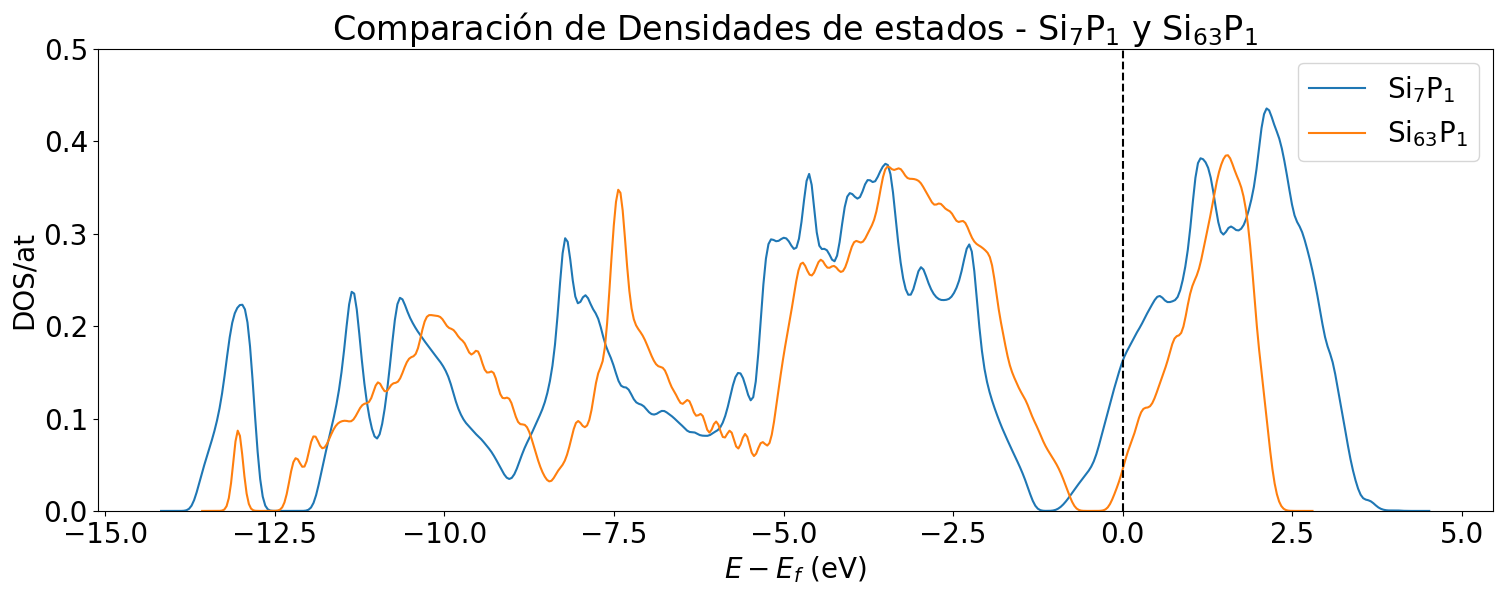

In [102]:
plt.plot(e_SiPDiamond - ef_SiPDiamond, dos_SiPDiamond/SiPDiamond.get_global_number_of_atoms(), label='Si$_{7}$P$_1$')
plt.plot(e_sc_SiPDiamond2x2x2 - ef_sc_SiPDiamond2x2x2,dos_sc_SiPDiamond2x2x2/sc_SiPDiamond2x2x2.get_global_number_of_atoms(), label='Si$_{63}$P$_1$')
plt.ylim((0, 0.5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS/at')
plt.title('Comparación de Densidades de estados - Si$_{7}$P$_1$ y Si$_{63}$P$_1$')
plt.legend()